## 0. Install Packages and Requirements

In [1]:
!git clone https://github.com/horseee/DeepCache.git

Cloning into 'DeepCache'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 483 (delta 110), reused 87 (delta 50), pack-reused 315
Receiving objects: 100% (483/483), 76.21 MiB | 28.27 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [2]:
!pip install diffusers
!pip install matplotlib
%cd DeepCache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.0 MB/s eta 0:00:00
/content/DeepCache


## 1. Running the Original Stable Diffusion Pipeline

In [3]:
import time
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
baseline_pipe = StableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    torch_dtype=torch.float16
).to("cuda:0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [30]:
prompt = "house in water "

In [33]:
set_random_seed(42)
start_time = time.time()

origin_output = baseline_pipe(
    prompt, output_type='pt', return_dict=True
).images
use_time = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

## 2. Running the Stable Diffusion Pipeline + DeepCache

In [8]:
!pip install --upgrade DeepCache


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 2.3 MB/s eta 0:00:00


In [9]:
from DeepCache import *

In [31]:
set_random_seed(42)
start_time = time.time()
deepcache_output = deepcache_pipe(
    prompt,
    cache_interval=5, cache_layer_id=0, cache_block_id=0, uniform=True,
    output_type='pt', return_dict=True
).images
deepcache_use_time = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

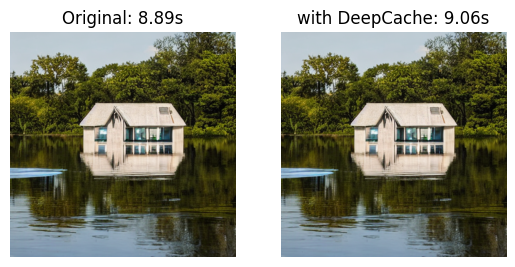

In [34]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(origin_output[0].cpu().float().permute(1, 2, 0))
axarr[0].axis('off')
axarr[0].set_title('Original: {:.2f}s'.format(use_time))

axarr[1].imshow(deepcache_output[0].cpu().float().permute(1, 2, 0))
axarr[1].axis('off')
axarr[1].set_title('with DeepCache: {:.2f}s'.format(deepcache_use_time))

plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

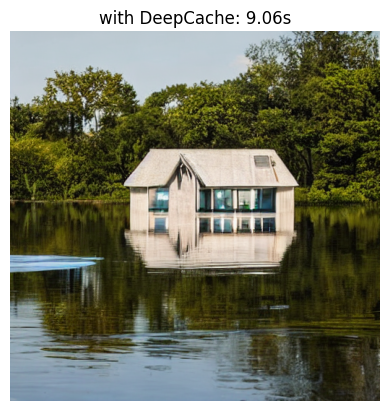

In [35]:
ig, ax = plt.subplots()

# Plot the deepcache
ax.imshow(deepcache_output[0].cpu().float().permute(1, 2, 0))
ax.axis('off')
ax.set_title('with DeepCache: {:.2f}s'.format(deepcache_use_time))

# Save only the deepcache plot to a PNG file
plt.savefig('deepcache_output.png', bbox_inches='tight', pad_inches=0.1)

# Show only the deepcache plot
plt.show()

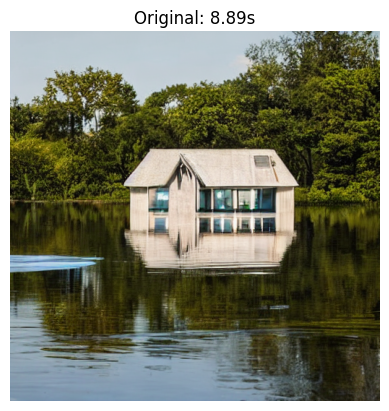

In [36]:
import time
import matplotlib.pyplot as plt

# ... (your existing code)

# Create a figure for the original plot
fig, ax = plt.subplots()

# Plot the original
ax.imshow(origin_output[0].cpu().float().permute(1, 2, 0))
ax.axis('off')
ax.set_title('Original: {:.2f}s'.format(use_time))

# Save only the original plot to a PNG file
plt.savefig('original_output.png', bbox_inches='tight', pad_inches=0.1)

# Show only the original plot
plt.show()


In [1]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def hello():
    return 'Hello, world from Saturn!'

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=8084)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8084
INFO:werkzeug:Press CTRL+C to quit
